In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler as MM
from sklearn.metrics import mean_squared_error as MSE, mean_absolute_error as MAE, r2_score, mean_absolute_percentage_error as MAPE   #MSE-average of the squared differences between predicted and actual values, penalizes larger errors more than smaller ones #MAE-average of the absolute differences between predicted and actual values. Straightforward measure of prediction accuracy.
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential as sq    #allows us to build a linear stack of layers in Keras.
from tensorflow.keras.layers import LSTM, Dense, Dropout    #LTSM-used for adding long short term memory units; Dense-fully connected neural network layer;Dropout-used to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training time
from tensorflow.keras.callbacks import EarlyStopping as ES, ReduceLROnPlateau as rLRp    #ES-stops training when a monitored metric has stopped improving; rLRp-reduces the learning rate when a metric has stopped improving
from keras.models import load_model as lm

In [2]:
class Data :

    def __init__(self) :
        self.dataframe = pd.DataFrame([])

    #Read data from CSV dataset(s)
    def read(self, filename : str) :
        """Reads values/data from CSV files into dataframe"""
        if os.path.exists(filename) :
            self.dataframe = pd.read_csv(filename)
            print(f"Data successfully read from {filename}.")
        else :
            print(f"Error: The file {filename} does not exist.")

    #Check for null values in the dataset(s)
    def check_null_values(self) :
        """Checks for null values in the dataframe."""
        print("Null Values Before Cleaning:")
        print(self.dataframe.isnull().sum())

    #Cleaning the dataset :
    def clean_dataset(self) :
        """Cleans the dataset by removing null values"""
        if self.dataframe is not None :
            original_shape = self.dataframe.shape #store the original shape of the DataFrame
            self.dataframe = self.dataframe.dropna() #drop all rows with null values; dropna() is a Pandas method that, by default, drops all rows that contain at least one null value.
            cleaned_shape = self.dataframe.shape #store the cleaned shape of DataFrame
            print(f"Dataset cleaned. Original shape: {original_shape}, Cleaned shape: {cleaned_shape}.")
        else:
            print("Error: No data to clean. Please read a dataset first.")

    # Normalize the data
    def normalize(self):
        """Normalizes numeric columns in the dataframe"""
        # Select columns to scale
        columns_to_scale = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

        # Ensure all specified columns are in the DataFrame
        columns_to_scale = [col for col in columns_to_scale if col in self.dataframe.columns]

        if columns_to_scale:
            # Select the data to scale
            data_to_scale = self.dataframe[columns_to_scale]

            # Initialize the MinMaxScaler
            self.scaler = MM()

            # Fit and transform the data
            scaled_data = self.scaler.fit_transform(data_to_scale)

            # Update the DataFrame with the scaled data
            self.dataframe[columns_to_scale] = scaled_data

            print("Data successfully normalized:")
            print(self.dataframe.head())
        else:
            print("Error: No columns to normalize. Please ensure the dataframe contains the necessary columns.")

    def visualize_open(self) :
      """Plot graph for open stock values v/s date"""
      if 'Date' in self.dataframe.columns and 'Open' in self.dataframe.columns:
            self.dataframe['Date'] = pd.to_datetime(self.dataframe['Date'])
            plt.figure(figsize=(14, 7))
            plt.plot(self.dataframe['Date'], self.dataframe['Open'], label='Open Stock Prices')
            plt.title('Open Stock Prices Over Time')
            plt.xlabel('Date')
            plt.ylabel('Open Stock Price')
            plt.legend()
            plt.show()
      else:
        print("Date and/or Open column not found in the dataframe")

    def visualize_close(self) :
      """Plot graph for close stock values v/s date"""
      if 'Date' in self.dataframe.columns and 'Close' in self.dataframe.columns :
            self.dataframe['Date'] = pd.to_datetime(self.dataframe['Date'])
            plt.figure(figsize=(14, 7))
            plt.plot(self.dataframe['Date'], self.dataframe['Close'], label='Close Stock Prices')
            plt.title('Close Stock Prices Over Time')
            plt.xlabel('Date')
            plt.ylabel('Close Stock Price')
            plt.legend()
            plt.show()
      else:
          print("Date and/or Close column not found in the dataframe")


    def print_head(self):
        """Prints the head of the dataframe."""
        print("Head of the DataFrame:")
        print(self.dataframe.head())

    def print_description(self):
        """Prints the description of the dataframe."""
        print("\nDescription of the DataFrame:")
        print(self.dataframe.describe())


In [3]:
data = Data()

In [4]:
data.read('/content/sample_data/MBG.DE.csv')

Data successfully read from /content/sample_data/MBG.DE.csv.


In [5]:
data.check_null_values()

Null Values Before Cleaning:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [6]:
data.clean_dataset()

Dataset cleaned. Original shape: (2541, 7), Cleaned shape: (2541, 7).


In [7]:
data.print_head()

Head of the DataFrame:
         Date       Open       High        Low      Close  Adj Close   Volume
0  2014-05-30  58.047653  58.222321  57.889622  57.972797  32.494484  3592922
1  2014-06-02  58.222321  58.496799  57.207588  57.656734  32.317326  2759788
2  2014-06-03  57.864670  58.047653  57.398891  57.956161  32.485165  2880702
3  2014-06-04  57.947845  57.947845  57.024605  57.648418  32.312664  3117640
4  2014-06-05  57.731590  58.713055  57.448795  58.480164  32.778873  5463058


In [8]:
data.print_description()


Description of the DataFrame:
              Open         High          Low        Close    Adj Close        Volume
count  2541.000000  2541.000000  2541.000000  2541.000000  2541.000000  2.541000e+03
mean     55.359880    55.948084    54.708630    55.332688    40.429126  4.382397e+06
std      11.866506    11.919771    11.778056    11.858232    12.385067  2.458627e+06
min      18.061396    19.225842    17.479174    18.165363    13.722126  0.000000e+00
25%      47.950241    48.607323    47.301479    47.983513    31.176374  2.816618e+06
50%      56.558826    57.020000    55.880001    56.467335    36.647671  3.874127e+06
75%      64.000000    64.751541    63.150002    63.849998    49.997208  5.275236e+06
max      78.949471    79.905975    77.577087    79.673088    71.070671  2.443688e+07


In [9]:
data.normalize()

Data successfully normalized:
         Date      Open      High       Low     Close  Adj Close    Volume
0  2014-05-30  0.656717  0.642656  0.672410  0.647194   0.327338  0.147029
1  2014-06-02  0.659586  0.647180  0.661061  0.642055   0.324249  0.112935
2  2014-06-03  0.653712  0.639778  0.664245  0.646924   0.327176  0.117883
3  2014-06-04  0.655078  0.638133  0.658017  0.641920   0.324168  0.127579
4  2014-06-05  0.651526  0.650744  0.665075  0.655443   0.332297  0.223558


In [10]:
data.print_head()
data.print_description()

Head of the DataFrame:
         Date      Open      High       Low     Close  Adj Close    Volume
0  2014-05-30  0.656717  0.642656  0.672410  0.647194   0.327338  0.147029
1  2014-06-02  0.659586  0.647180  0.661061  0.642055   0.324249  0.112935
2  2014-06-03  0.653712  0.639778  0.664245  0.646924   0.327176  0.117883
3  2014-06-04  0.655078  0.638133  0.658017  0.641920   0.324168  0.127579
4  2014-06-05  0.651526  0.650744  0.665075  0.655443   0.332297  0.223558

Description of the DataFrame:
              Open         High          Low        Close    Adj Close       Volume
count  2541.000000  2541.000000  2541.000000  2541.000000  2541.000000  2541.000000
mean      0.612575     0.605177     0.619480     0.604271     0.465696     0.179335
std       0.194890     0.196436     0.195981     0.192793     0.215961     0.100611
min       0.000000     0.000000     0.000000     0.000000     0.000000     0.000000
25%       0.490882     0.484203     0.496229     0.484787     0.304354     0

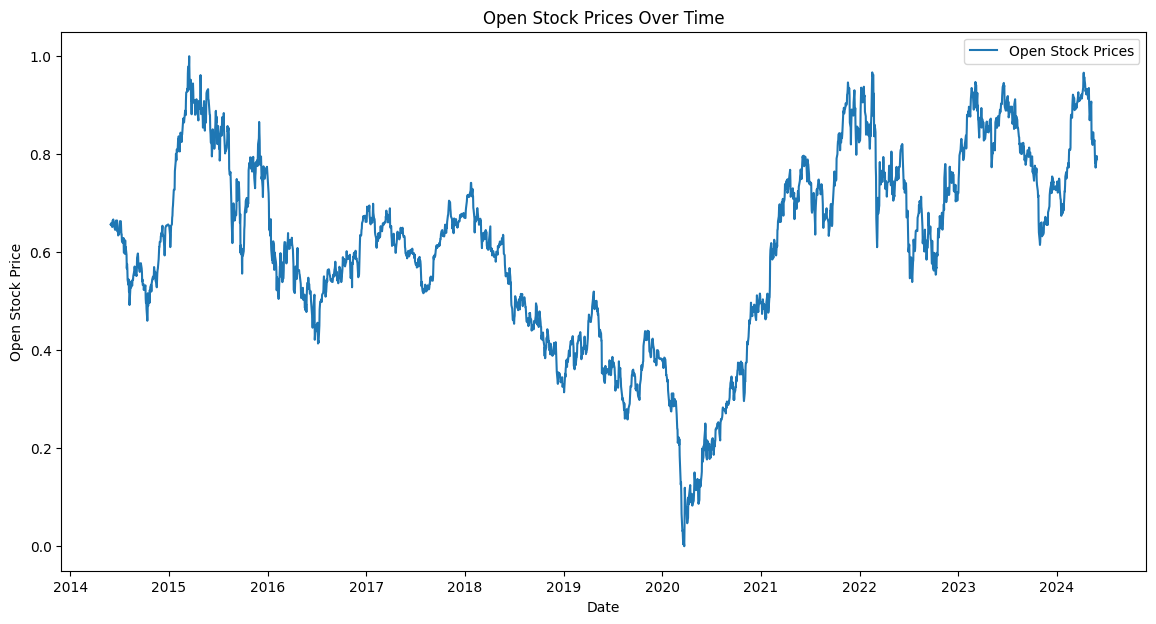

In [11]:
data.visualize_open()

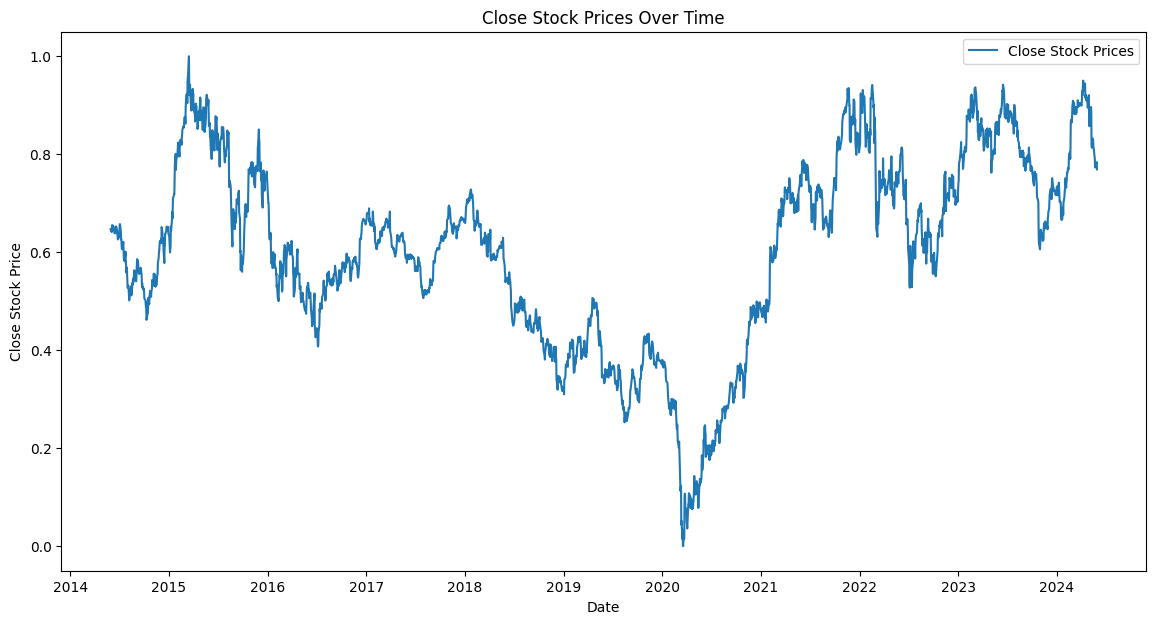

In [12]:
data.visualize_close()

In [13]:
class model_train_seq_LSTM :

    def __init__(self, dataframe, scaler) :
        self.dataframe = dataframe
        self.scaler = scaler

    def prep_data_lstm(self, feature_col = 'Close', look_back = 60) :   #"look back" refers to the number of previous time steps that the model uses to make predictions for the next time step.
        """Prepare data for LSTM by creating sequences"""
        data = self.dataframe[feature_col].values     # Extract the feature column values
        data = data.reshape(-1, 1)  # Reshape to (n_samples, 1)
        X, y = [], []
        for i in range(len(data) - look_back):
            X.append(data[i:i + look_back])     # Append sequences of length 'look_back'
            y.append(data[i + look_back])       # Append the next value as the target
        X, y = np.array(X), np.array(y)
        # Split data while preserving the number of features
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)
        return X_train, X_test, y_train, y_test.reshape(-1, 1)

    def build_train_lstm(self, feature_col = 'Close', look_back = 60, epochs = 100, batch_size = 32):
        """Build and train the LSTM model"""
        X_train, X_test, y_train, y_test = self.prep_data_lstm(feature_col, look_back)

        model = sq()    # Initialize the model
        model.add(LSTM(units = 50, return_sequences = True, input_shape = (look_back, 1)))
        model.add(LSTM(units = 50))   #this layer does not have return_sequences=True, which means it will only return the final output of the sequence, not the full sequence.
        model.add(Dense(1))     #This is the output layer of the model. Since we are predicting a single value (the next day's stock price), this layer has one neuron.

        #LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)) adds an LSTM layer to the model.
        #50 is the number of units in this LSTM layer, which means the layer will have 50 LSTM cells.
        #return_sequences=True means this layer will return the full sequence of outputs for each input sequence, not just the final output. This is necessary because we are stacking another LSTM layer on top.
        #input_shape=(X_train.shape[1], 1) specifies the shape of the input data for this layer.
        #X_train.shape[1] is the number of time steps (look-back period), and 1 is the number of features (since we are using just one feature, the stock price).

        model.compile(optimizer = 'adam', loss = 'mean_squared_error')     # Compile the model using Adam optimizer and mean squared error loss

         # Train the model with the training data
        model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = (X_test, y_test))

        self.model = model    # Save the trained model
        self.X_test = X_test  # Save the test features
        self.y_test = y_test  # Save the test targets


    def predict_plot(self):
        """Make predictions and plot the results"""
        predictions = self.model.predict(self.X_test)   # Predict the test data
        predictions = predictions.reshape(-1, 1)    # Reshape the predictions

        # Extract the 'Close' column from the original dataframe
        self.close_scaler = MM(feature_range = (0, 1))  # Create a new scaler for just the 'Close' column
        self.close_scaler.fit(self.dataframe['Close'].values.reshape(-1, 1))  # Fit the scaler to the 'Close' column

        # Inverse transform predictions using the scaler fitted on 'Close' column
        predictions = self.close_scaler.inverse_transform(predictions)
        # Inverse transform actual 'Close' values
        actual = self.close_scaler.inverse_transform(self.y_test)

        plt.figure(figsize = (14, 7))
        plt.plot(actual, label = 'Actual Stock Price')
        plt.plot(predictions, label = 'Predicted Stock Price')
        plt.title('Actual vs Predicted Stock Prices')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()


    def evaluate_model(self):
        """Calculates and prints evaluation metrics."""
        predictions = self.model.predict(self.X_test)   # Predict the test data
        predictions = self.close_scaler.inverse_transform(predictions)    # Inverse transform predictions
        actual = self.close_scaler.inverse_transform(self.y_test)      # Inverse transform actual values; inverse transform = Inverse transform is the process of converting the model's scaled predictions back to their original scale (e.g., actual stock prices) using the same scaler that was used to normalize the data, making the results interpretable and comparable to the original data.

        mse = MSE(actual, predictions)
        rmse = np.sqrt(mse)
        mae = MAE(actual, predictions)
        r2 = r2_score(actual, predictions)
        mape = MAPE(actual, predictions)

        print(f"Mean Squared Error (MSE): {mse}")
        print(f"Root Mean Squared Error (RMSE): {rmse}")
        print(f"Mean Absolute Error (MAE): {mae}")
        print(f"R-squared (R2): {r2}")

        # Custom accuracy metric
        accuracy = 100 - (mape * 100)  # Accuracy can be interpreted as 100% - MAPE%
        print(f"Model Accuracy: {accuracy:.2f}%")

    def save_model(self, model_path = '/content/sample_data/model.h5') :
        """Saves the trained model to a file."""
        self.model.save(model_path)
        print(f"Model saved to {model_path}")

    def load_model(self, model_path = '/content/sample_data/model.h5') :
        """Loads a saved model from a file."""
        self.model = lm(model_path)
        print(f"Model loaded from {model_path}")

In [14]:
trainer = model_train_seq_LSTM(data.dataframe, data.scaler)

In [15]:
trainer.build_train_lstm(feature_col = 'Close', look_back = 60, epochs = 100, batch_size = 32)

Epoch 1/100
62/62 [==============================] - 8s 60ms/step - loss: 0.0352 - val_loss: 0.0021
Epoch 2/100
62/62 [==============================] - 3s 45ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 3/100
62/62 [==============================] - 3s 46ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 4/100
62/62 [==============================] - 4s 71ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 5/100
62/62 [==============================] - 3s 55ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 6/100
62/62 [==============================] - 3s 47ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 7/100
62/62 [==============================] - 3s 46ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/100
62/62 [==============================] - 4s 72ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 9/100
62/62 [==============================] - 3s 47ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 10/100
62/62 [==============================] - 3s 46ms/step - loss: 0.0010 - val_loss: 9.8428

16/16 [==============================] - 1s 16ms/step


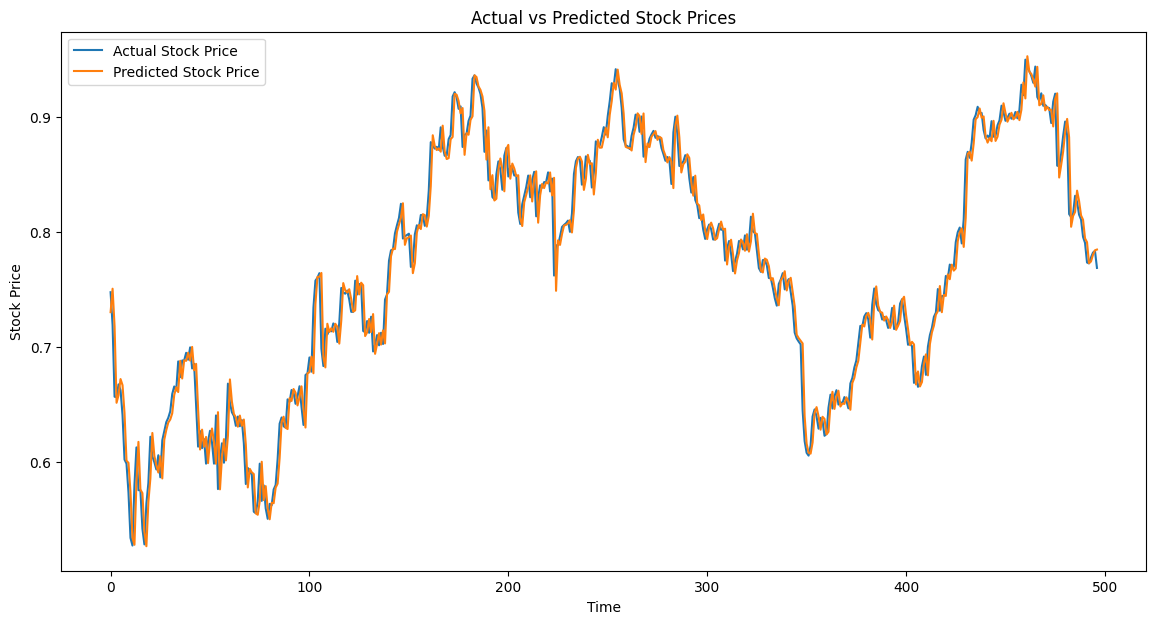

In [16]:
trainer.predict_plot()

In [17]:
trainer.evaluate_model()

16/16 [==============================] - 0s 17ms/step
Mean Squared Error (MSE): 0.00030975848777330535
Root Mean Squared Error (RMSE): 0.017599957038961923
Mean Absolute Error (MAE): 0.01258802056746687
R-squared (R2): 0.971918077590251
Model Accuracy: 98.28%


In [18]:
trainer.save_model('model/lstm_model_mercedez.h5')

Model saved to model/lstm_model_mercedez.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
trainer.load_model('model/lstm_model_mercedez.h5')

Model loaded from model/lstm_model_mercedez.h5
